In [8]:
%matplotlib inline
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
imageio.plugins.ffmpeg.download()

<class 'numpy.ndarray'>
(160, 320, 3)


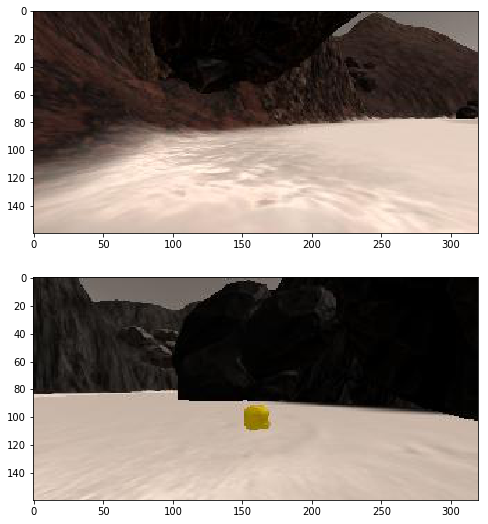

In [9]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)

# print("This is the type of img {}".format(type(img_list)))
# print(len(img_list))
# print(img_list[282])

idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])

rock = '../calibration_images/example_rock1.jpg'
rock = mpimg.imread(rock)

print(type(rock))
print(rock.shape)

fig = plt.figure(figsize=(12,9))
plt.subplot(211)
plt.imshow(image)
plt.subplot(212)
plt.imshow(rock)

# let's use the coloring to extract the navigable terrain

In [10]:
def color_thresh(img,l_thresh=(0,0,0),u_thresh=(255,255,255)):
    """This function returns a matrix with the same shape as
    the image but with pixels 0 or 1 depending on whether they're
    above your specified threshold or not. 
    """
    binary_output = np.zeros_like(img[:,:,0])
    
    above_thresh = (img[:,:,0] >= l_thresh[0]) & (img[:,:,1] >= l_thresh[1]) & (img[:,:,2] >= l_thresh[2])
    print(above_thresh)
    below_thresh = (img[:,:,0] <= u_thresh[0]) & (img[:,:,1] <= u_thresh[1]) & (img[:,:,2] <= u_thresh[2])
    
    true_matrix = above_thresh & below_thresh
    
    binary_output[true_matrix] = 1
    
    return binary_output

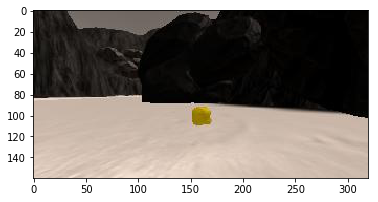

In [11]:
%matplotlib inline
plt.imshow(rock)

In [12]:
rock_l = (90,50,0)
rock_u = (200,190,60)
ground_l =(190,170,160)
ground_u =(255,255,255)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


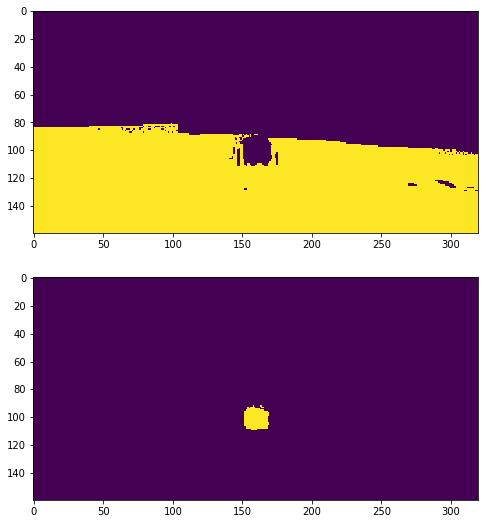

In [13]:
rock_binary = color_thresh(rock,rock_l,rock_u)
ground_binary = color_thresh(rock,ground_l,ground_u)

fig = plt.figure(figsize=(12,9))
plt.subplot(211)
plt.imshow(ground_binary)
plt.subplot(212)
plt.imshow(rock_binary)

# We are eventually going to create a top-down map. To do so we need to warp the image to give us a top-down view.

### Let's use OpenCV's perspective transform!

In [73]:
def perspective_transform(img, src, dst):
    #first get the transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    #then, apply it.
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    return warped

In [74]:
grid = '../calibration_images/example_grid1.jpg'
grid = mpimg.imread(grid)

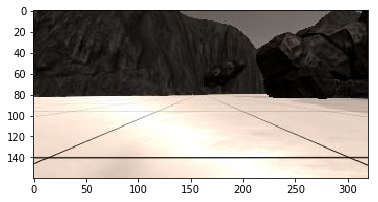

In [75]:
plt.imshow(grid)

In [26]:
BL = [15,140]
BR = [301,140]
TR = [200,96]
TL = [119,96]

dst_size = 5
bottom_offset = 6

BL_n = [image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset]
BR_n = [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset]
TR_n = [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset]
TL_n = [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset]

In [27]:
source = np.float32([BL,BR,TR,TL])
destination = np.float32([BL_n,BR_n,TR_n,TL_n])

<IPython.core.display.Javascript object>


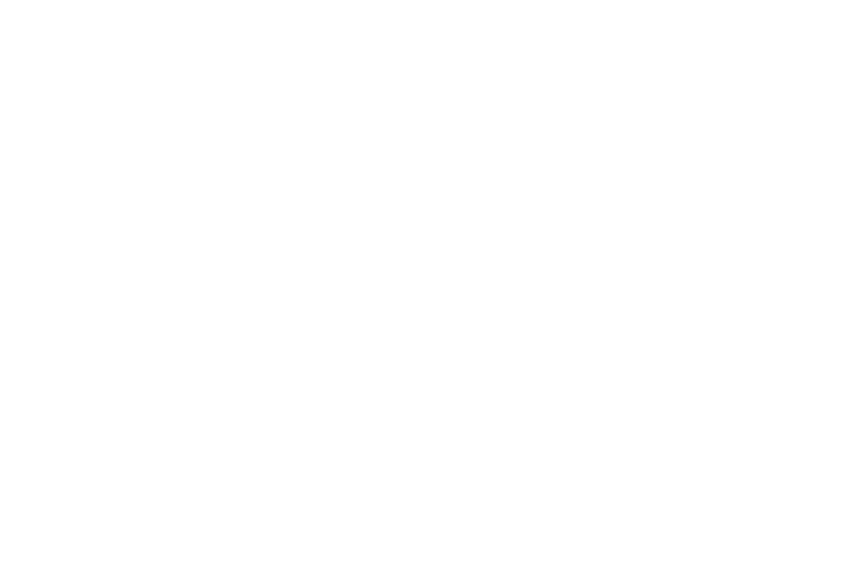

<IPython.core.display.Javascript object>


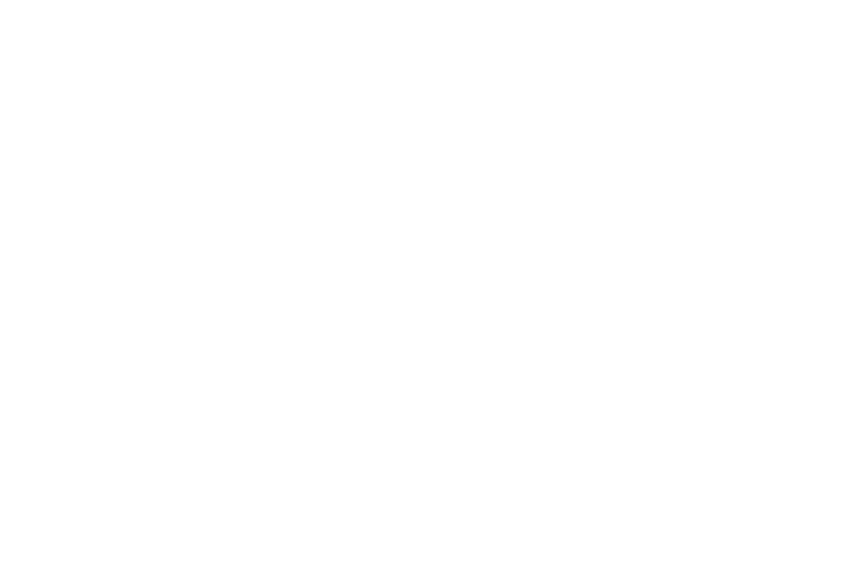

In [28]:
warped = perspective_transform(grid,source,destination)
plt.imshow(warped)

## Now let's get into the rover's coordinate system

### We want our coordinate system to be one where 0,0 is the rover's position and it is facing the +x direction.

In [29]:
image.shape

(160, 320, 3)

In [30]:
def rover_coordinates(binary_image):
    ypos, xpos = binary_image.nonzero()
    x_pixel = -(ypos - binary_image.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_image.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

## Putting it all together

<IPython.core.display.Javascript object>


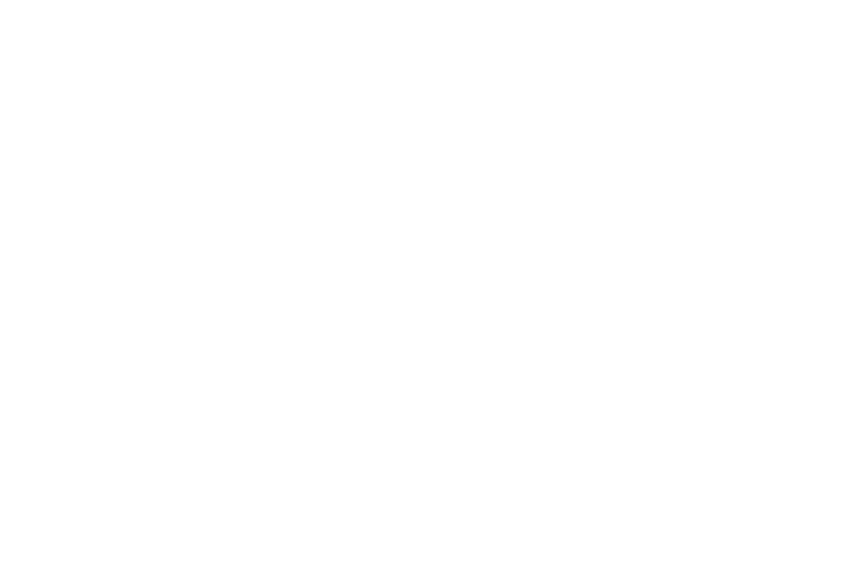

<IPython.core.display.Javascript object>


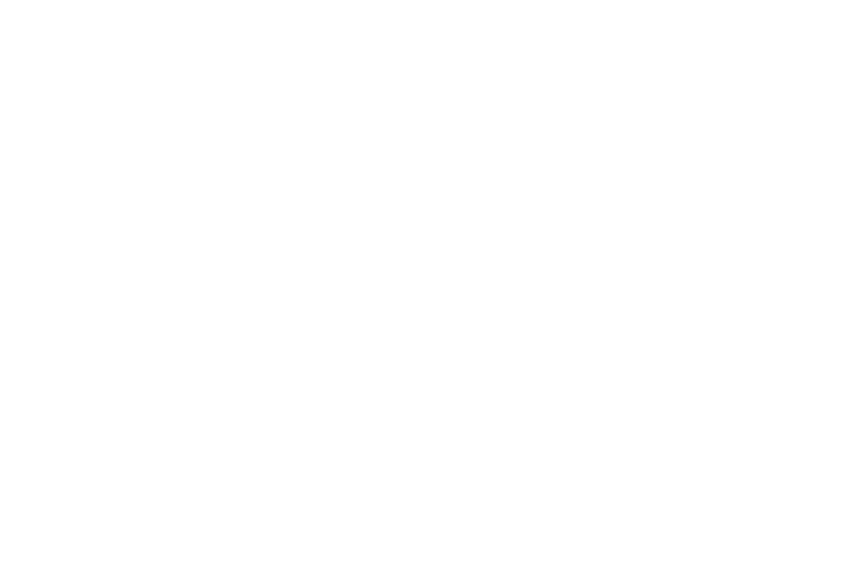

In [31]:
binary = color_thresh(grid,ground_l,ground_u)
warped = perspective_transform(binary,source,destination)
x,y = rover_coordinates(warped)
plt.xlim(0,grid.shape[0])
plt.ylim(-grid.shape[1]/2,grid.shape[1]/2)
plt.plot(x, y, '.')

## Now, once we have the overhead image, we can place it somewhere on a map given that we know the position and yaw of our rover

In [32]:
def rotate_pix(xpix, ypix, yaw):
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))                      
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos 
    return xpix_translated, ypix_translated

def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    #rotate according to yaw
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    #translate and scale according to reported position
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    #clip to stay within map
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    
    return x_pix_world, y_pix_world

<IPython.core.display.Javascript object>


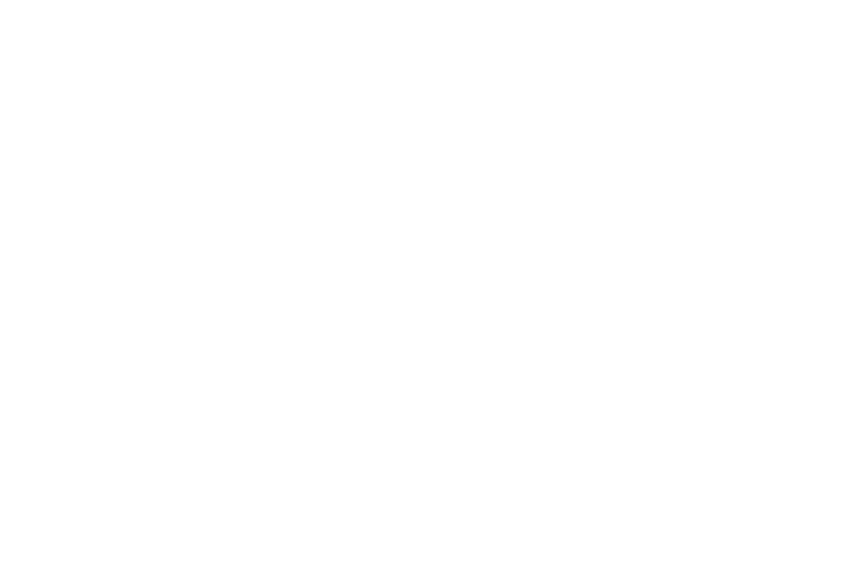

<IPython.core.display.Javascript object>


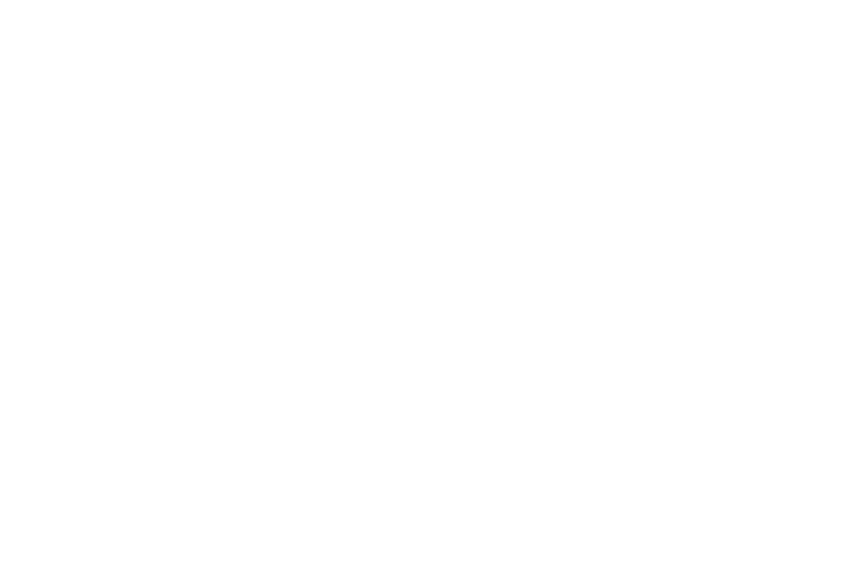

In [33]:
x_w,y_w = pix_to_world(x,y,100,100,45,200,2*dst_size)
plt.xlim(0,200)
plt.ylim(0,200)
plt.plot(x_w, y_w, '.')

# We'll now get all of our data into our workspace

<IPython.core.display.Javascript object>


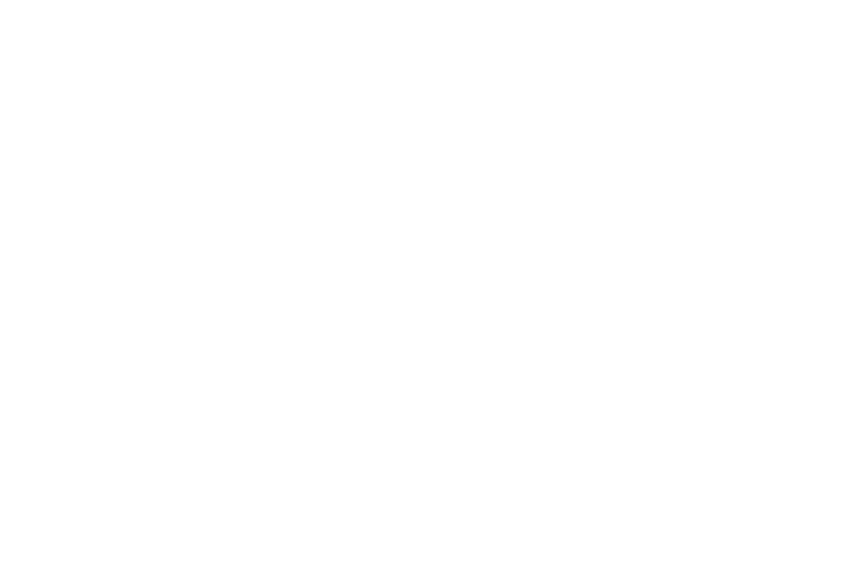

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<IPython.core.display.Javascript object>


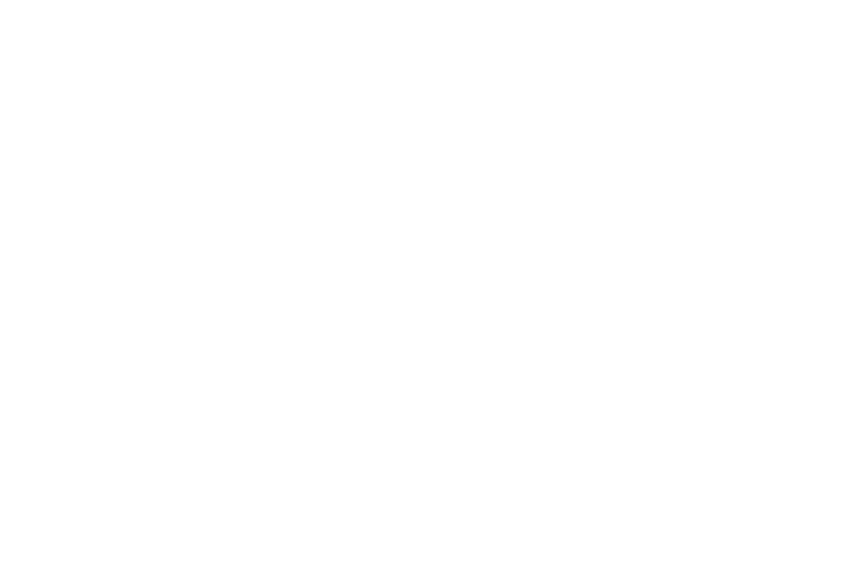

In [34]:
import pandas as pd
df = pd.read_csv('../test_dataset/robot_log2.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist()

ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)


class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap
        
data = Databucket()
plt.imshow(data.ground_truth)

<IPython.core.display.Javascript object>


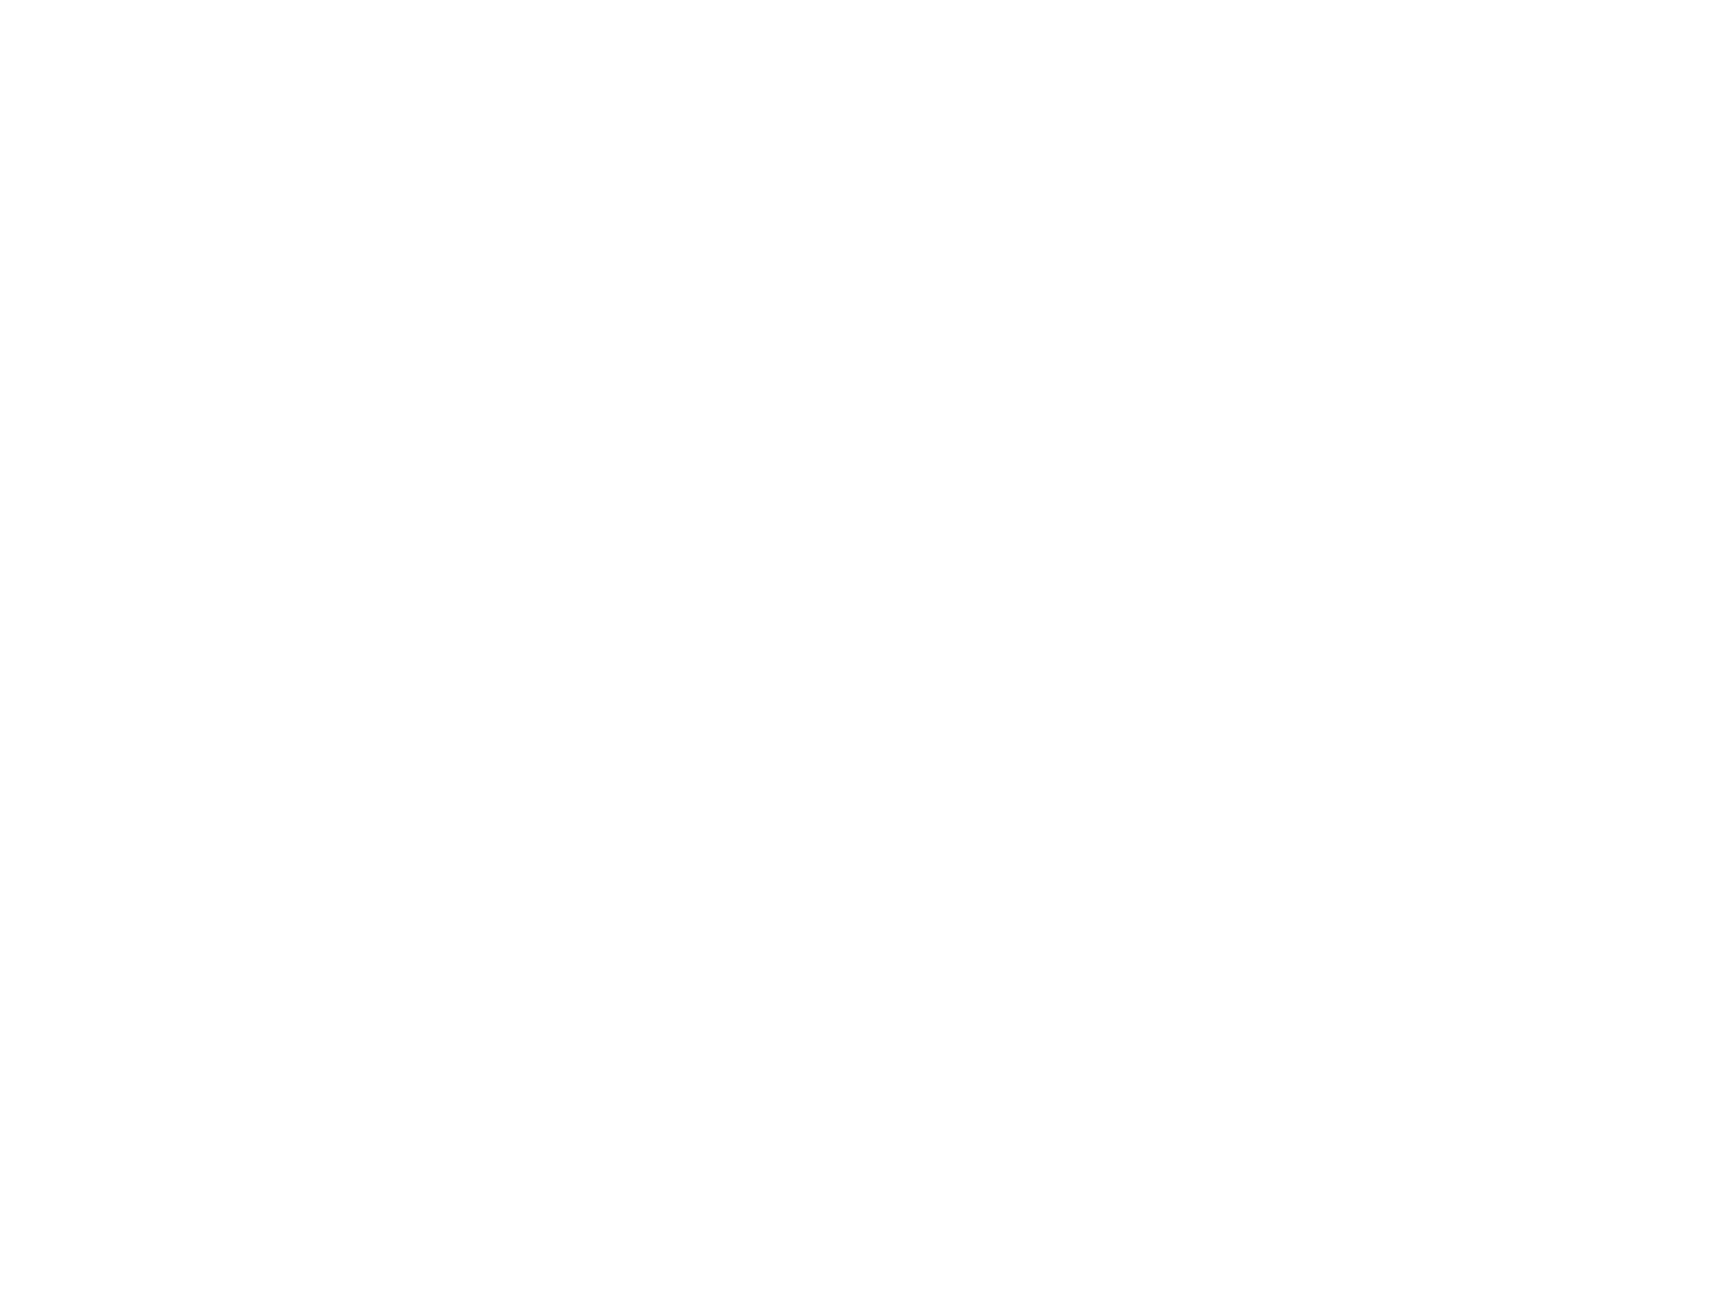

<IPython.core.display.Javascript object>


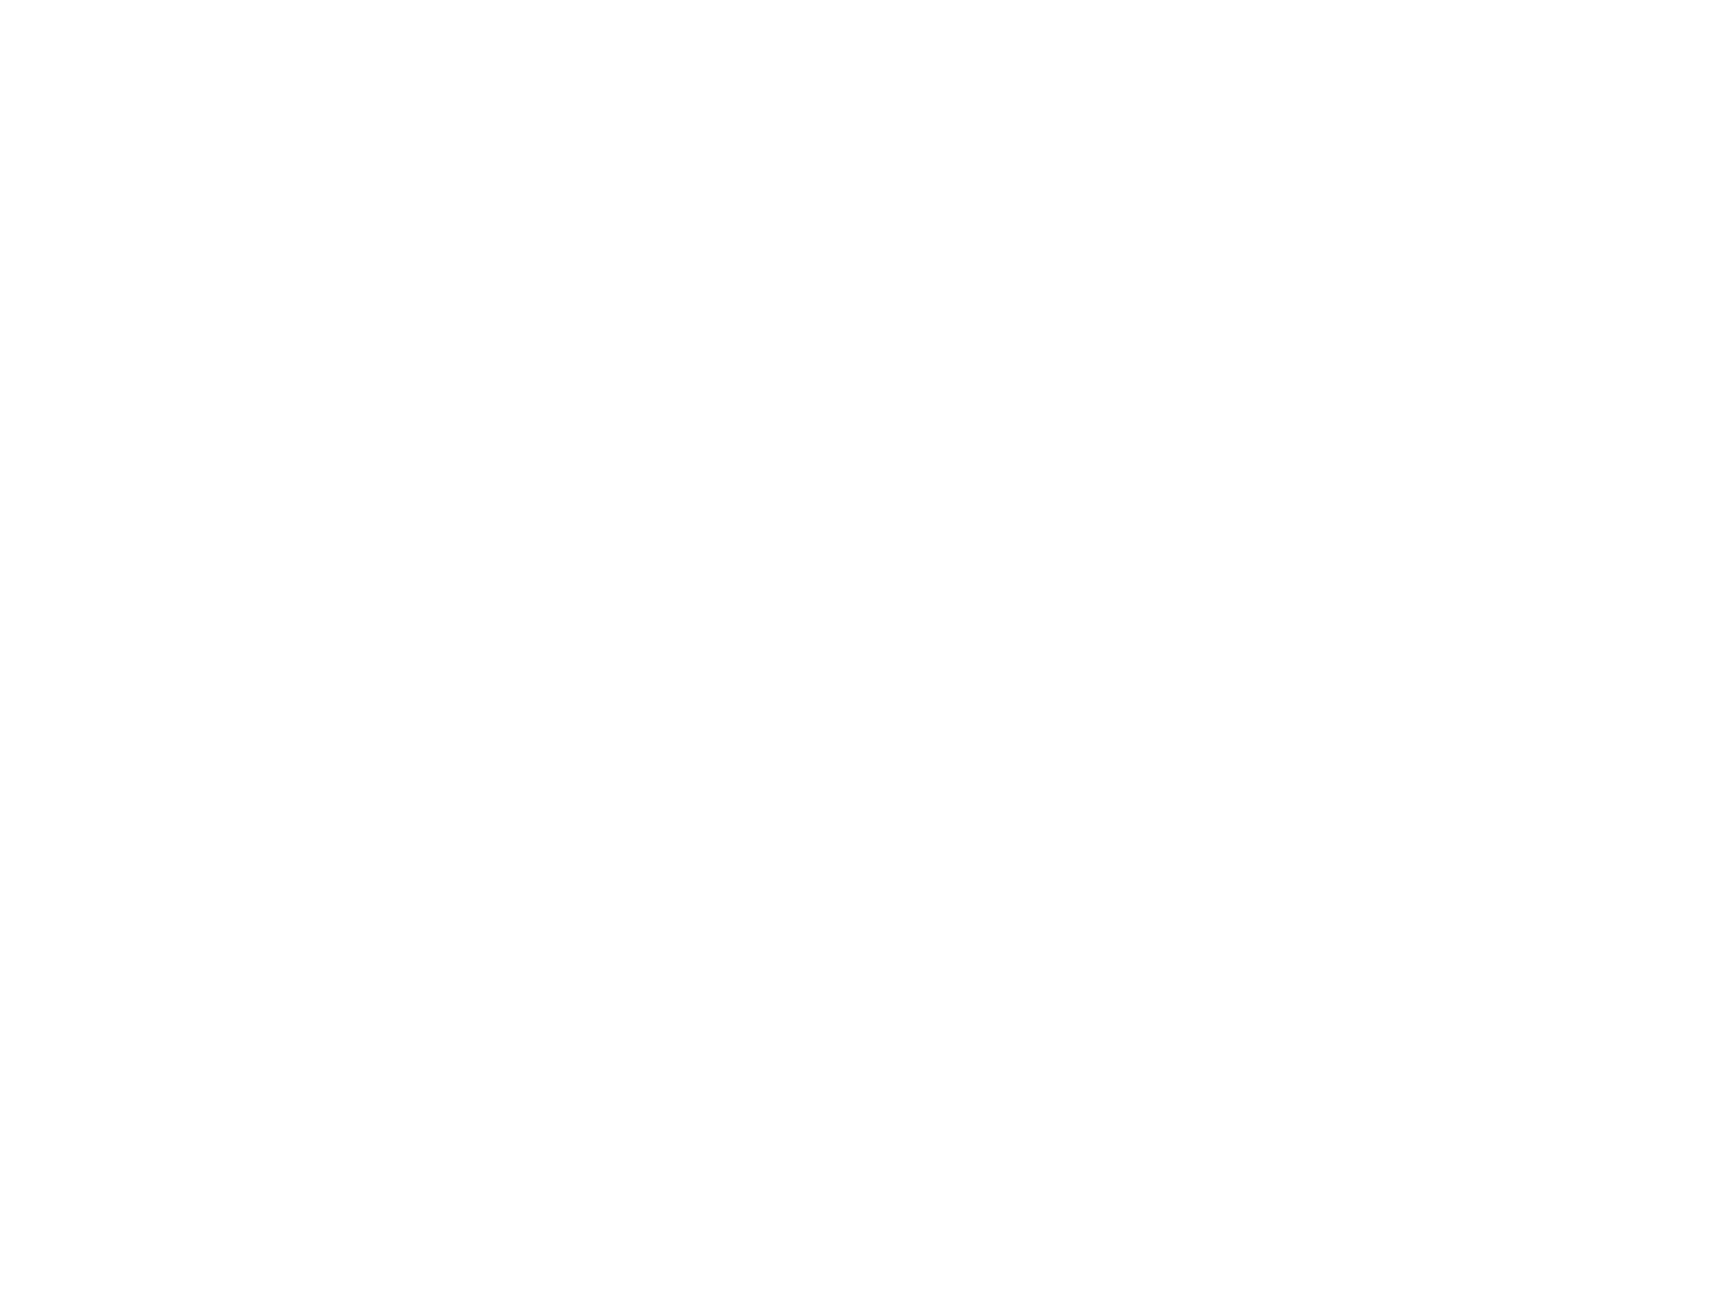

In [35]:
image = rock
dst_size = 5 
bottom_offset = 6
source = np.float32([BL,BR,TR,TL])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
    
warped = perspective_transform(image, source, destination)

rock_l = (90,50,0)
rock_u = (200,190,60)
ground_l =(190,170,160)
ground_u =(255,255,255)
rock_threshed = color_thresh(warped,rock_l,rock_u)
ground_threshed = color_thresh(warped,ground_l,ground_u)

x_g, y_g = rover_coordinates(ground_threshed)
x_r, y_r = rover_coordinates(rock_threshed)

fig = plt.figure(figsize=(12,9))
plt.subplot(211)
plt.plot(x_g, y_g, '.')
plt.subplot(212)
plt.plot(x_r, y_r, '.')

<IPython.core.display.Javascript object>


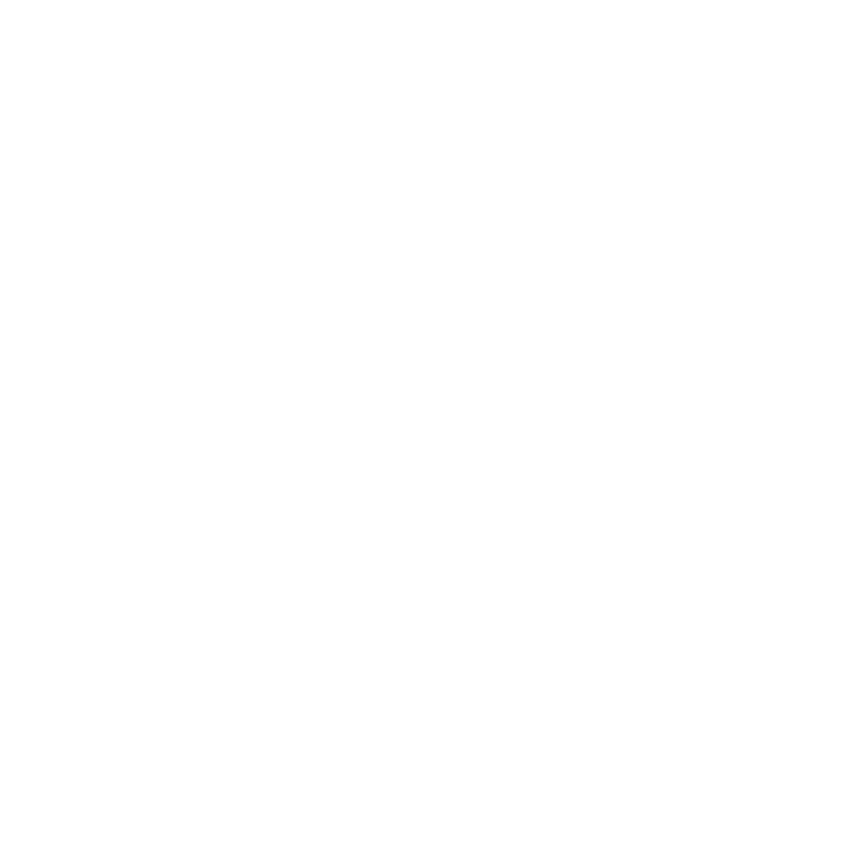

<IPython.core.display.Javascript object>


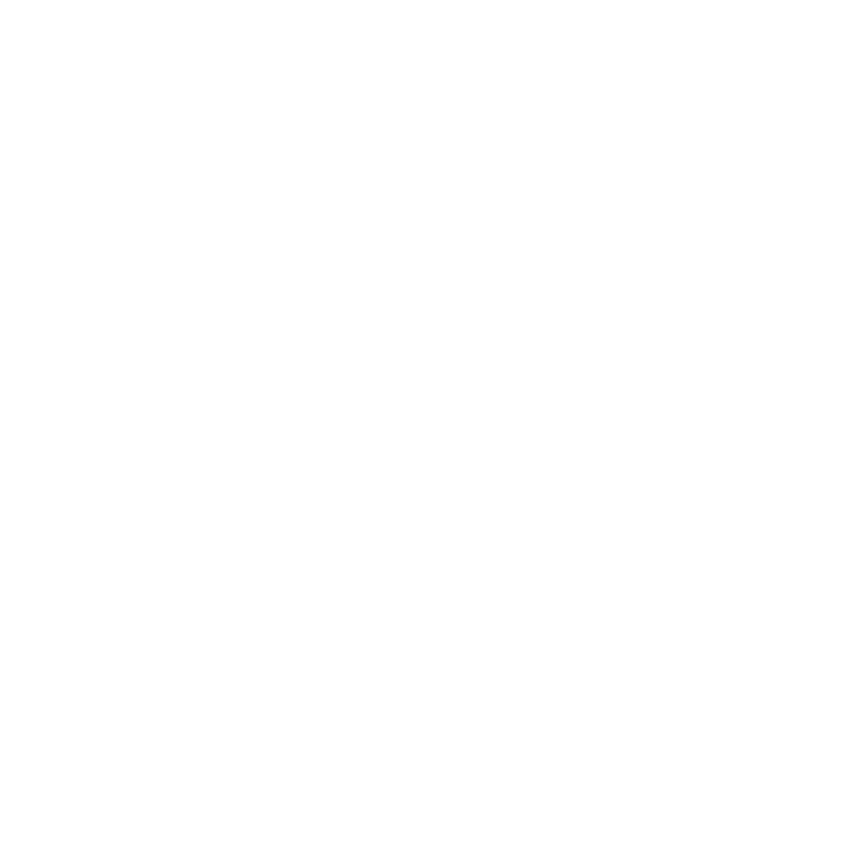

In [36]:
scale = 2*dst_size
x_g_world, y_g_world = pix_to_world(x_g,y_g,50,50,45,200,scale)
x_r_world, y_r_world = pix_to_world(x_r,x_r,50,50,45,200,scale)
fig = plt.figure(figsize=(6,6))
plt.subplot(211)
plt.xlim(0,200)
plt.ylim(0,200)
plt.plot(x_g_world, y_g_world, '.')
plt.subplot(212)
plt.xlim(0,200)
plt.ylim(0,200)
plt.plot(x_r_world, y_r_world, '.')

<IPython.core.display.Javascript object>


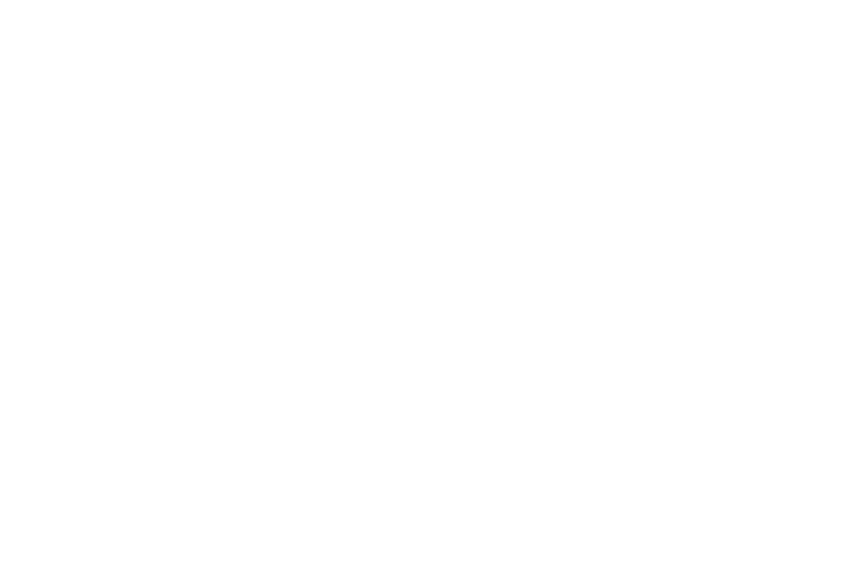

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<IPython.core.display.Javascript object>


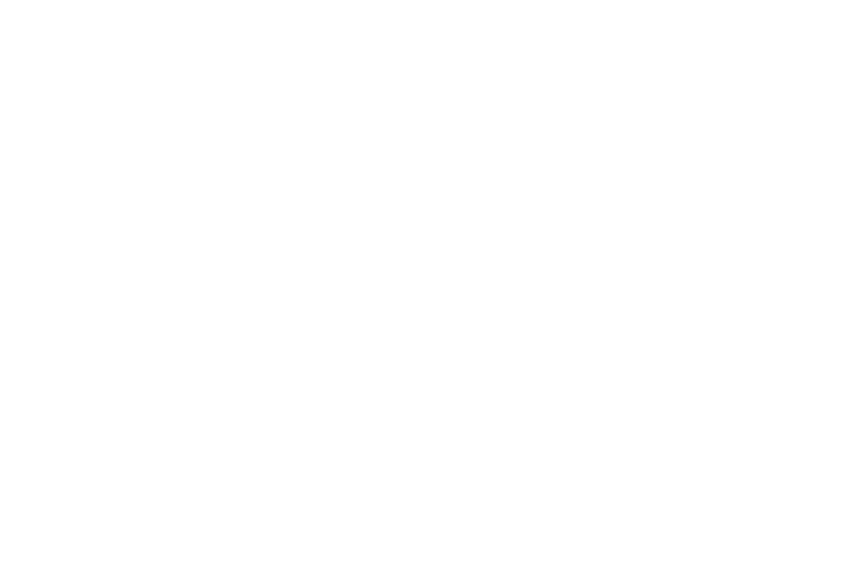

In [37]:
data.worldmap[x_g_world,y_g_world] = (0,255,0)
data.worldmap[x_r_world,y_r_world] = (255,0,0)
plt.imshow(data.worldmap)

In [38]:
def process_image(image):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    # print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    # TODO: 
    # 1) Define source and destination points for perspective transform
    dst_size = 5 
    bottom_offset = 6
    source = np.float32([BL,BR,TR,TL])
    destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
    
    # 2) Apply perspective transform
    warped = perspective_transform(image, source, destination)
    
    
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    rock_l = (90,50,0)
    rock_u = (180,170,60)
    ground_l =(190,170,160)
    ground_u =(255,255,255)
    rock_threshed = color_thresh(warped,rock_l,rock_u)
    ground_threshed = color_thresh(warped,ground_l,ground_u)
    
    
    # 4) Convert thresholded image pixel values to rover-centric coords
    x_g, y_g = rover_coordinates(ground_threshed)
    x_r, y_r = rover_coordinates(rock_threshed)
    
    # 5) Convert rover-centric pixel values to world coords
    scale = 2*dst_size
    x_g_world, y_g_world = pix_to_world(x_g,y_g,data.xpos[data.count],data.ypos[data.count],data.yaw[data.count],200,scale)
    x_r_world, y_r_world = pix_to_world(x_r,x_r,data.xpos[data.count],data.ypos[data.count],data.yaw[data.count],200,scale)
    
    # 6) Update worldmap (to be displayed on right side of screen)
    #data.worldmap[x_r_world,y_r_world] = (255,0,0)
    data.worldmap[x_g_world,y_g_world] = (0,255,0)
    
        # Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          data.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          data.worldmap[navigable_y_world, navigable_x_world, 2] += 1

        
    # 7) Make a mosaic image, below is some example code
    
    # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((image.shape[0] + data.worldmap.shape[0], image.shape[1]*2, 3))
    
    # Next you can populate regions of the image with various output
    # Here I'm putting the original image in the upper left hand corner     
    #output_image[0:image.shape[0], 0:image.shape[1]] = image

    # Let's create more images to add to the mosaic, first a warped image
    #warped = perspective_transform(image, source, destination)
    #output_image[0:image.shape[0], image.shape[1]:] = warped

    # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 1, 0)
    # Flip map overlay so y-axis points upward and add to output_image 
    output_image[image.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)

    if data.count < len(data.images) - 1:
        data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

In [39]:
data.worldmap.shape,data.ground_truth.shape

((200, 200, 3), (200, 200, 3))

In [40]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '../output/test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(img_list, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

ModuleNotFoundError: No module named 'requests'

In [41]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

NameError: name 'output' is not defined